In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import random
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%precision 2

'%.2f'

In [2]:
#Make a function to shift, transform, and shift back
def cosmo_transform(input_box):
    #Shifting the zero frequency component to the center
    shift_1 = np.fft.fftshift(input_box)
    
    #Fourier transform after the shift
    #Need to fourier transform here, shift does not transform alone
    transformed_box = np.fft.fftn(shift_1)
    
    #Shifting the zero-frequency component back to its assumed numpy original position
    shift_2 = np.fft.ifftshift(transformed_box)
    
    return shift_2


#Creating a function to generate the k_x frequency array
def kx_frequency_array(one_D_array):
    #Fourier transform to frequency space
    #Need to fourier transform here, shift does not transform alone
    #1D array containing the wavevectors 
    #By multiplying by the total # of pixels, we convert them to pixel freq.
    kfreq = np.fft.fftfreq(one_D_array)*2*np.pi
    
    #Shifting back to its assumed numpy position
    k_x = np.fft.fftshift(kfreq)
    
    return k_x


#Creating a function to generate the k_y frequency array
def ky_frequency_array(one_D_array):
    #Fourier transform to frequency space
    #Need to fourier transform here, shift does not transform alone
    #1D array containing the wavevectors 
    #By multiplying by the total # of pixels, we convert them to pixel freq.
    kfreq = np.fft.fftfreq(one_D_array)*2*np.pi
    
    #Shifting back to its assumed numpy position
    k_y = np.fft.fftshift(kfreq)
    
    return k_y


#Creating a function to generate the k_z frequency array
def kz_frequency_array(one_D_array):
    #Fourier transform to frequency space
    #Need to fourier transform here, shift does not transform alone
    #1D array containing the wavevectors 
    #By multiplying by the total # of pixels, we convert them to pixel freq.
    kfreq = np.fft.fftfreq(one_D_array)*2*np.pi
    
    #Shifting back to its assumed numpy position
    k_z = np.fft.fftshift(kfreq)
    
    return k_z


#Function to generate start and end binning arrays
def create_bins(max_bin_value, num_bins):
    #Defining the size of the bins
    bin_size = max_bin_value / num_bins
    #Defining the starting points of our array
    bin_starts = [bin_size * i for i in range(num_bins)]
    #Defining the ending points of our array
    bin_ends = [bin_size * (i+1) for i in range(num_bins)]
    return bin_starts, bin_ends


#Finding the element positions given our k parameters
#Changing find_element_positions to the 3D case
def find_element_positions(input_k, start, end):
    
    positions = []
    #Iterating through each element in the start and end arrays
    for k in range(len(start)):
        sub_positions = []
        #Iterating through first dimension of input_k
        for i in range(len(input_k)):
            #Iterating through second dimension of input_k
            for j in range(len(input_k[0])):
                #Iterating through third dimension of input_k
                for l in range(len(input_k[0][0])):
                    #For elements within our inputted desired range
                    if start[k] <= input_k[i][j][l] <= end[k]:
                        sub_positions.append((i, j, l))
        positions.append(sub_positions)
    
    #Return tuples that given the locations of the elements in the given range
    return positions


#Find corresponding (i,j,k) positions in Fourier transform array 
#Should be same dimensions as k array
def get_corresponding_values(input_k, fourier_array, start, end):
    #Calling function that returns position tuples
    positions = find_element_positions(input_k, start, end)
    
    #Empty list to store the values
    values = []
    
    #Iterate through rows in the positions array
    for pos_row in positions:
        #Initialize an empty list to store each row's values
        row_values = []
        #Iterate through triplets of indices in the row
        for i, j, k in pos_row:
            #Index into Fourier array and store value
            row_values.append(fourier_array[i][j][k])
            
        #Append values for this row into overall values list
        values.append(row_values)
    
    return values


#Finding averages of the values at each position
def avg_corresponding_values(input_k, fourier_array, start, end):
    
    #Get our corresponding values 2D array
    values = get_corresponding_values(input_k, fourier_array, start, end)
    
    #Creating empty avg_values array
    avg_values = []
    #Separating out ranges
    for row in values:
        row_sum = 0
        #For each value in the row
        for i in row:
            row_sum += i
            avg = row_sum/len(row)
            
        avg_values.append(avg)
    
    return avg_values


#Creating the power spectra plot
def power_spectra_plot(input_k, fourier_array, start, end, sigma):
    
    #Getting the average fourier value for the chosen k range
    avg_values = avg_corresponding_values(input_k, fourier_array, start, end)
    print(avg_values)
    #List of integers from our chosen range values
    #Will be the labels for the x-axis
    range_values = list(range(len(start)))
    
    plt.figure(figsize = (8,8))
    plt.scatter(range_values, avg_values)
    
    #Plot specifications
    plt.xlabel("$k$", size = 25)
    plt.ylabel("$P(k)$", size = 25)
    plt.tick_params(bottom=True, top=True, left=True, right=True)
    plt.errorbar(range_values, avg_values, yerr=sigma, fmt='o', color = 'black')
    plt.suptitle("Power Spectrum from a 3D Box", size = 30)
    plt.tight_layout()
    
    plt.show()


In [3]:
def generate_pk_3D (npix, num_bins, sigma):
    
    #Creating an array with npix dimensions
    toy_box = np.random.normal(size = (npix, npix, npix))
    
    #Fourier transforming box (shifts included)
    k_box = cosmo_transform(toy_box)
    
    #Squaring values to find amplitude array
    amplitude = np.abs(k_box)**2
    
    #Dividing by original volume of box
    Volume = (npix)**3
    
    #getting the power spectra
    P_k = (amplitude/Volume)
    
    #Creating frequency arrays
    #THIS IS THE K_X ARRAY
    k_x = kx_frequency_array(npix)
    #THIS IS THE K_Y ARRAY
    k_y = ky_frequency_array(npix)
    #THIS IS THE K_Z ARRAY
    k_z = kz_frequency_array(npix)
    #Creating an array matching our toy box array
    kfreq3D = np.meshgrid(k_x, k_y, k_z, indexing="ij")
    
    #Normalisation factor
    #Finding distance between pixels
    k_values = np.sqrt(kfreq3D[0]**2 + kfreq3D[1]**2 + kfreq3D[2]**2)

    #Finding the maximum value of the k array
    max_k = np.max(k_values)
    
    #Defining the starting and ending arrays
    start, end = create_bins(max_k, num_bins)
    
    #Finding the element positions of the k-array using our given
    #k value ranges
    rings = find_element_positions(k_values, start, end)
    
    #Getting the corresponding fourier array values given positions
    co_values = get_corresponding_values(k_values, P_k, start, end)
    
    #Finding the average of all of these values at each index of 2D array
    averages = avg_corresponding_values(k_values, P_k, start, end)
   
    #Creating the power_spectra plot
    power_spectra_plot(k_values, P_k, start, end, sigma)
    
    return power_spectra_plot

[9.41864787662018e-05, 1.1262871965499095, 1.0873205744861876, 0.9649917757274891, 0.8717166330821957, 1.0300188942987711, 0.980758513452829, 0.9817421672137581, 0.9397490760974911, 1.028355822952075, 0.8132195406563918, 0.34298907870354023]


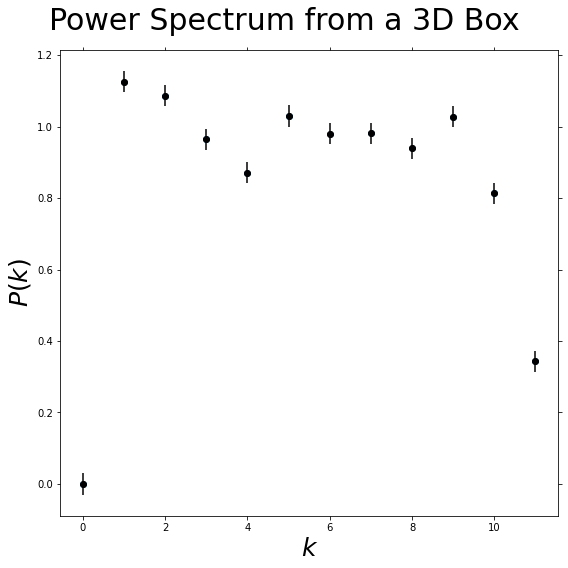

<function __main__.power_spectra_plot(input_k, fourier_array, start, end, sigma)>

In [4]:
generate_pk_3D(12, 12, 0.03)

In [5]:
"""
Description: Python script to access 21cmFAST brightness-temperature boxes 
located in .h5 file format.
"""

import h5py
import numpy as np

hf = h5py.File('HII_DIM_128_BOX_LEN_192_5_boxes_z5.75-9.50.h5', 'r')

redshifts = hf['redshifts'][:]
random_seed = hf['random_seeds'][:]
btemp_boxes = hf['brightness_temp_boxes'][:]

hf.close()

print('Random seed:', random_seed)
print('Redshifts:', redshifts)
print('Ionized fractions:', [np.round(1.0-(btemp_boxes[i] > 0).mean(),3) for i in range(btemp_boxes.shape[0])])

Random seed: [50]
Redshifts: [5.75 6.5  7.5  8.5  9.5 ]
Ionized fractions: [0.956, 0.815, 0.505, 0.257, 0.128]


In [6]:
#Addition of Higher Redshifts
hf = h5py.File('HII_DIM_128_BOX_LEN_192_2_boxes_z10.50-11.50.h5', 'r')

redshifts2 = hf['redshifts'][:]
random_seed = hf['random_seeds'][:]
btemp_boxes2 = hf['brightness_temp_boxes'][:]

hf.close()

print('Random seed:', random_seed)
print('Redshifts 2:', redshifts2)
print('Ionized fractions 2:', [np.round(1.0-(btemp_boxes2[i] > 0).mean(),3) for i in range(btemp_boxes2.shape[0])])


Random seed: [50]
Redshifts 2: [10.5 11.5]
Ionized fractions 2: [0.064, 0.032]


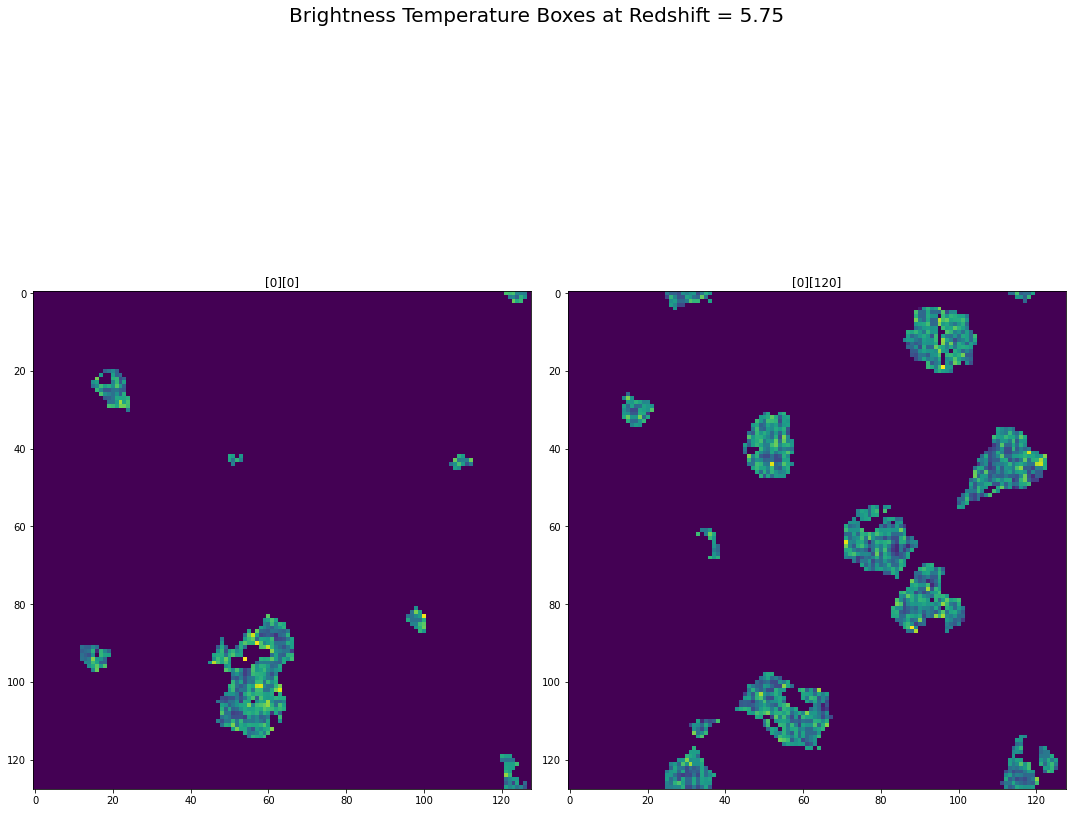

In [7]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(btemp_boxes[0][0])
ax1.set_title("[0][0]")

ax2.imshow(btemp_boxes[0][120])
ax2.set_title("[0][120]")

plt.suptitle("Brightness Temperature Boxes at Redshift = 5.75", size = 20)
plt.tight_layout()
plt.show()

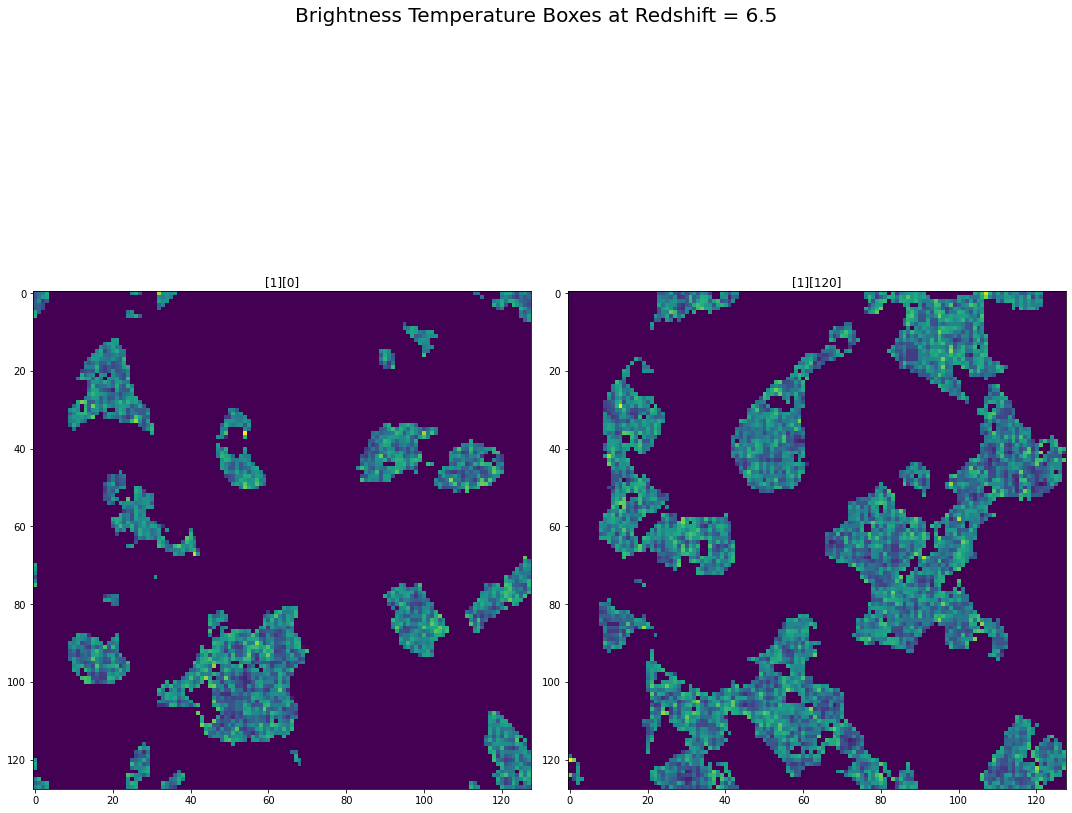

In [8]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(btemp_boxes[1][0])
ax1.set_title("[1][0]")

ax2.imshow(btemp_boxes[1][120])
ax2.set_title("[1][120]")

plt.suptitle("Brightness Temperature Boxes at Redshift = 6.5", size = 20)
plt.tight_layout()
plt.show()

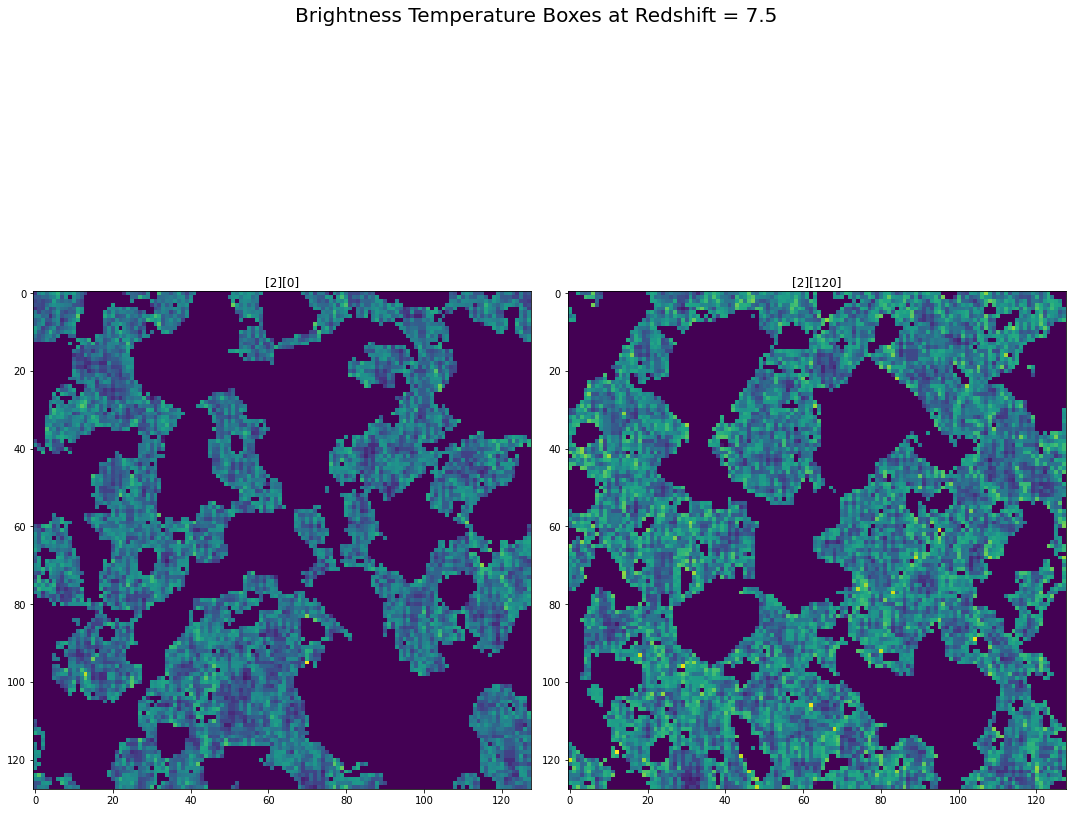

In [9]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(btemp_boxes[2][0])
ax1.set_title("[2][0]")

ax2.imshow(btemp_boxes[2][120])
ax2.set_title("[2][120]")

plt.suptitle("Brightness Temperature Boxes at Redshift = 7.5", size = 20)
plt.tight_layout()
plt.show()

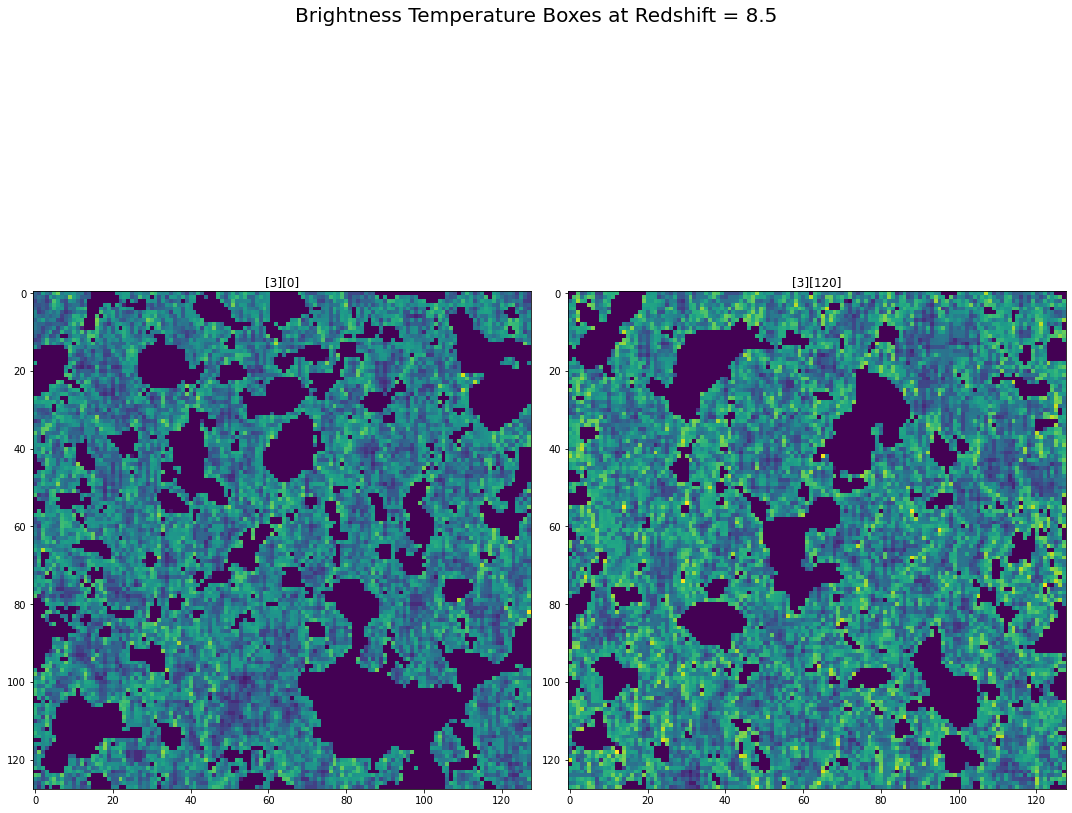

In [10]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(btemp_boxes[3][0])
ax1.set_title("[3][0]")

ax2.imshow(btemp_boxes[3][120])
ax2.set_title("[3][120]")

plt.suptitle("Brightness Temperature Boxes at Redshift = 8.5", size = 20)
plt.tight_layout()
plt.show()

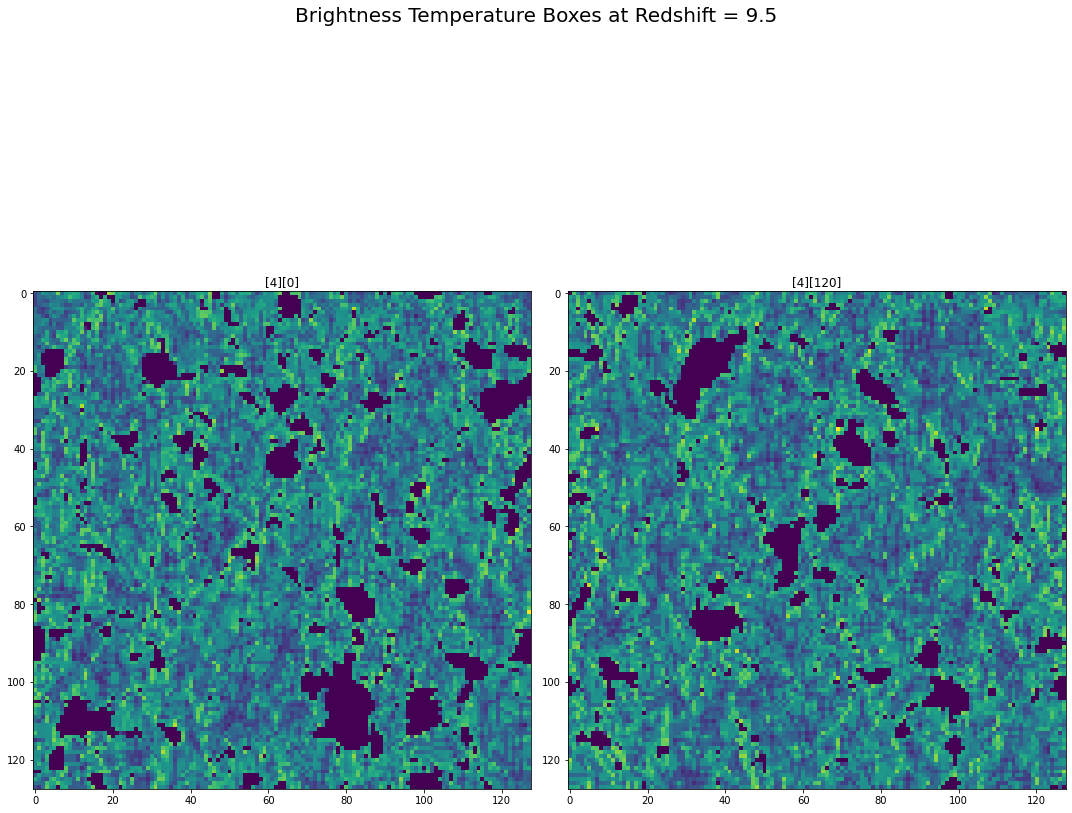

In [11]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(btemp_boxes[4][0])
ax1.set_title("[4][0]")

ax2.imshow(btemp_boxes[4][120])
ax2.set_title("[4][120]")

plt.suptitle("Brightness Temperature Boxes at Redshift = 9.5", size = 20)
plt.tight_layout()
plt.show()

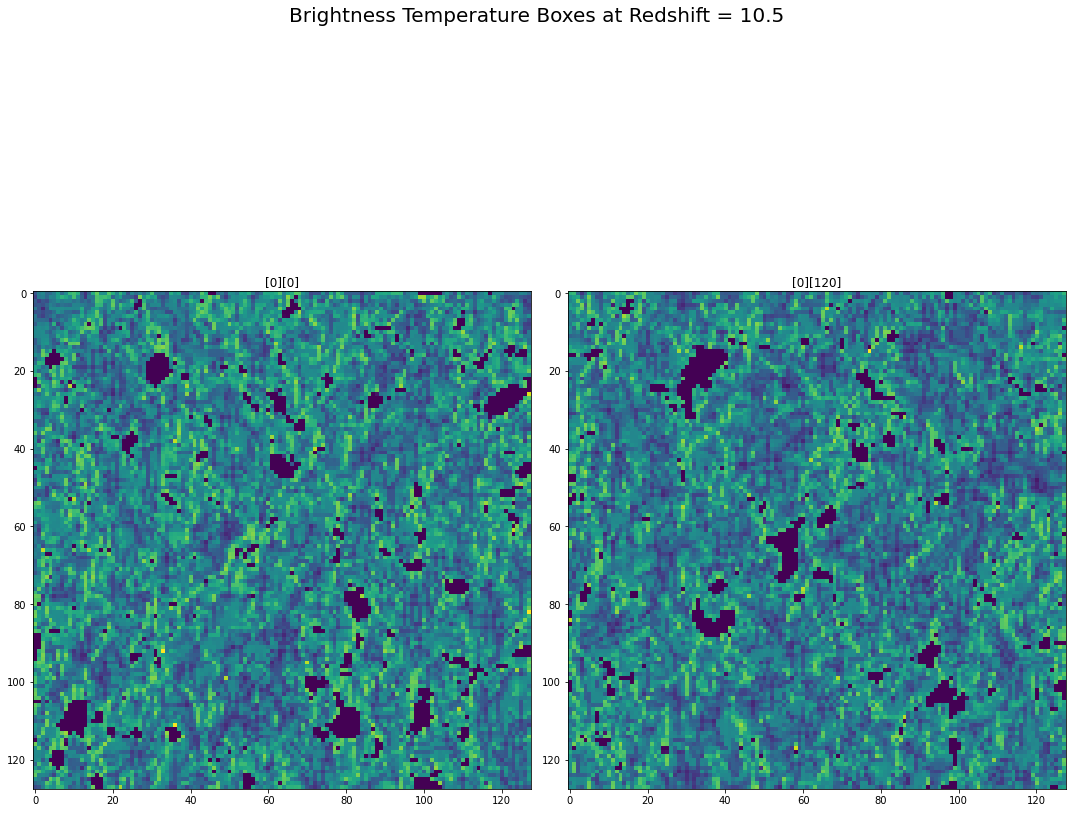

In [12]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(btemp_boxes2[0][0])
ax1.set_title("[0][0]")

ax2.imshow(btemp_boxes2[0][120])
ax2.set_title("[0][120]")

plt.suptitle("Brightness Temperature Boxes at Redshift = 10.5", size = 20)
plt.tight_layout()
plt.show()

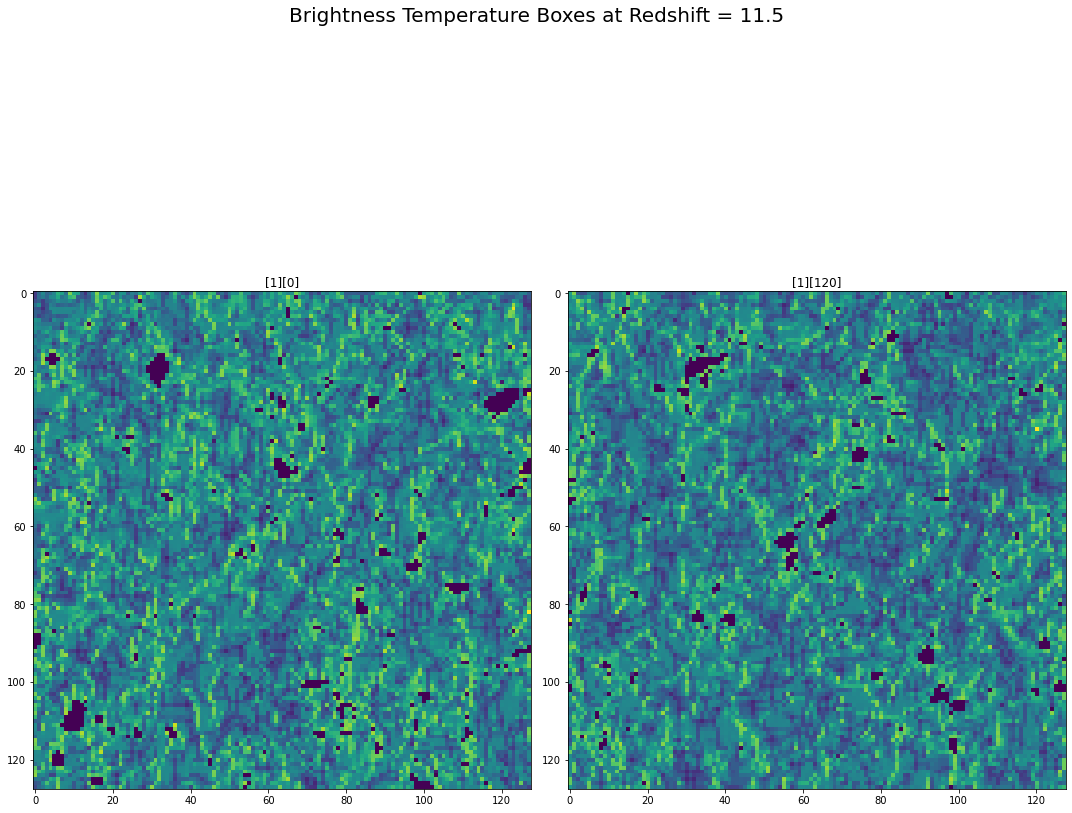

In [13]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(btemp_boxes2[1][0])
ax1.set_title("[1][0]")

ax2.imshow(btemp_boxes2[1][120])
ax2.set_title("[1][120]")

plt.suptitle("Brightness Temperature Boxes at Redshift = 11.5", size = 20)
plt.tight_layout()
plt.show()

In [14]:
#Creating the power spectra plot
def power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma):
    
    #Getting the average fourier value for the chosen k range
    avg_values = avg_corresponding_values(input_k, fourier_array, start, end)
    print(avg_values)
    
    #Rescaling the y-axis
    rescaled_values  = (np.power(start,3) * avg_values)/(2*np.pi**2)
    
    #List of integers from our chosen range values will be the labels for the x-axis
    range_values = list(range(len(start)))
    
    plt.figure(figsize = (8,8))
    plt.plot(range_values, rescaled_values)
    
    plt.style.use("fast")
    hfont = {'fontname':'Times New Roman'}
    
    #Plot specifications
    plt.xlabel(r"k [$\mathregular{Mpc^{-1}}$]", size=25, **hfont) 
    plt.ylabel(r"$\mathregular{k^3 P(k)/2\pi^{2} [mK^2]}$", size = 25, **hfont) 
    plt.suptitle("Power Spectrum from a 3D Box", size = 30, **hfont)
    
    #Tick Parameters
    plt.tick_params(bottom=True, top=True, left=True, right=True, which='major', 
                    direction = "in", labelsize=20, width=1.3, color='black')
    plt.tick_params(top= True, right = True, axis='both', which='minor', direction='in', 
                    labelsize = 20, length=5, width=1.3)
    plt.yticks(fontname = "Times New Roman") 
    plt.xticks(fontname = "Times New Roman")
    
    plt.tight_layout()
    
    plt.show()

In [15]:
#Changing a Few things for inputting real data

def generate_pk_3D (toy_box, npix, num_bins, sigma):
    
    #Fourier transforming box (shifts included)
    k_box = cosmo_transform(toy_box)
    
    #Squaring values to find amplitude array
    amplitude = np.abs(k_box)**2
    
    #Dividing by original volume of box
    Volume = (npix)**3
    
    #Getting the power spectra
    P_k = (amplitude/Volume)
    
    #Creating frequency arrays
    #THIS IS THE K_X ARRAY
    k_x = kx_frequency_array(npix)
    #THIS IS THE K_Y ARRAY
    k_y = ky_frequency_array(npix)
    #THIS IS THE K_Z ARRAY
    k_z = kz_frequency_array(npix)
    #Creating an array matching our toy box array
    kfreq3D = np.meshgrid(k_x, k_y, k_z, indexing="ij")
    
    #Normalisation factor
    #Finding distance between pixels
    k_values = np.sqrt(kfreq3D[0]**2 + kfreq3D[1]**2 + kfreq3D[2]**2)

    #Finding the maximum value of the k array
    max_k = np.max(k_values)
    
    #Defining the starting and ending arrays
    start, end = create_bins(max_k, num_bins)
    print(start)
    print(end)
    
    #Finding the element positions of the k-array using our given
    #k value ranges
    rings = find_element_positions(k_values, start, end)
    
    #Getting the corresponding fourier array values given positions
    co_values = get_corresponding_values(k_values, P_k, start, end)
    
    #Finding the average of all of these values at each index of 2D array
    averages = avg_corresponding_values(k_values, P_k, start, end)
   
    #Creating the power_spectra plot
    power_spectra_plot_rescaled(k_values, P_k, start, end, sigma)
    
    return power_spectra_plot_rescaled

In [16]:
box_1 = btemp_boxes[0]
print(box_1.shape)
print(redshifts[0])

(128, 128, 128)
5.75


[0.0, 0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547]
[0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547, 5.441398092702653]
[9722.376707716425, 1324.01831

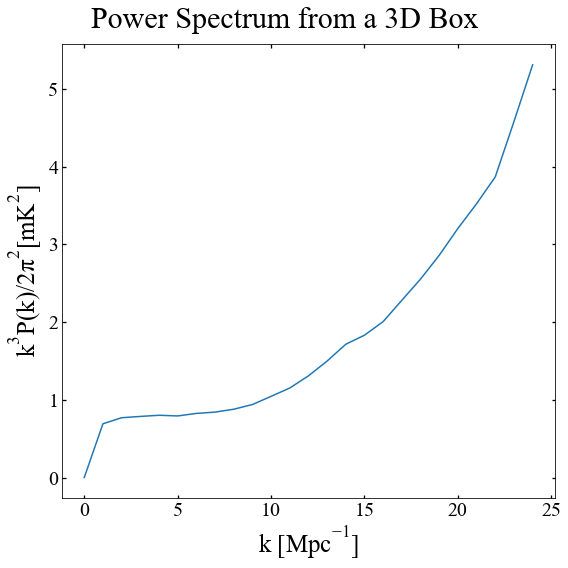

<function __main__.power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma)>

In [17]:
generate_pk_3D(box_1, 128, 25, 0.03)

In [18]:
box_2 = btemp_boxes[1]
print(box_2.shape)
print(redshifts[1])

(128, 128, 128)
6.5


[0.0, 0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547]
[0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547, 5.441398092702653]
[100915.82231520822, 6337.9312

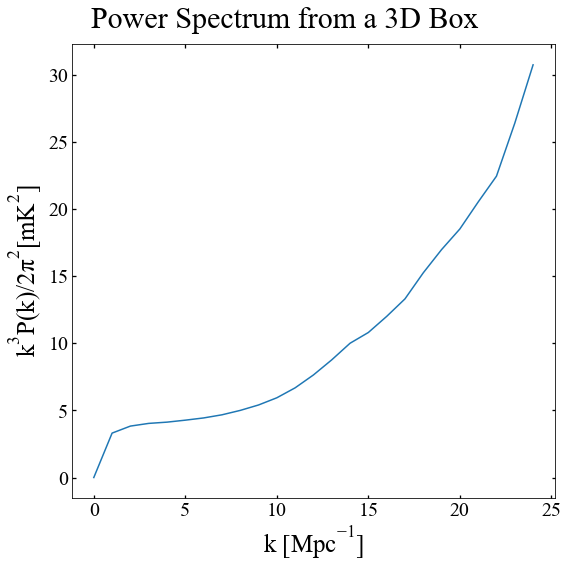

<function __main__.power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma)>

In [19]:
generate_pk_3D(box_2, 128, 25, 0.03)

In [20]:
box_3 = btemp_boxes[2]
print(box_3.shape)
print(redshifts[2])

(128, 128, 128)
7.5


[0.0, 0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547]
[0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547, 5.441398092702653]
[610171.9624606611, 15530.3511

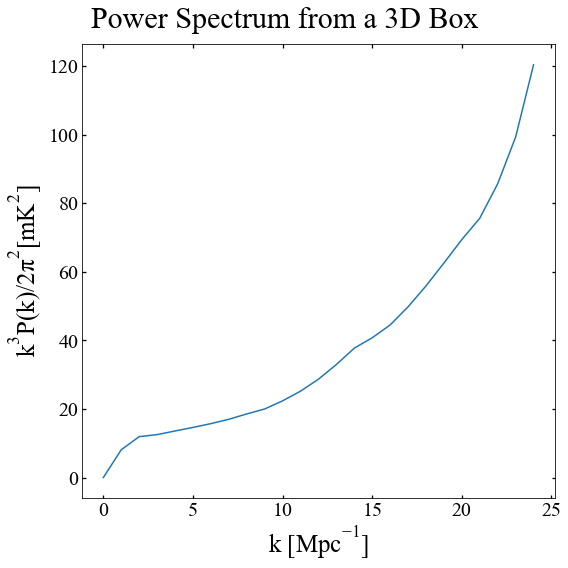

<function __main__.power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma)>

In [21]:
generate_pk_3D(box_3, 128, 25, 0.03)

In [22]:
box_4 = btemp_boxes[3]
print(box_4.shape)
print(redshifts[3])

(128, 128, 128)
8.5


[0.0, 0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547]
[0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547, 5.441398092702653]
[1589334.327195626, 16015.7542

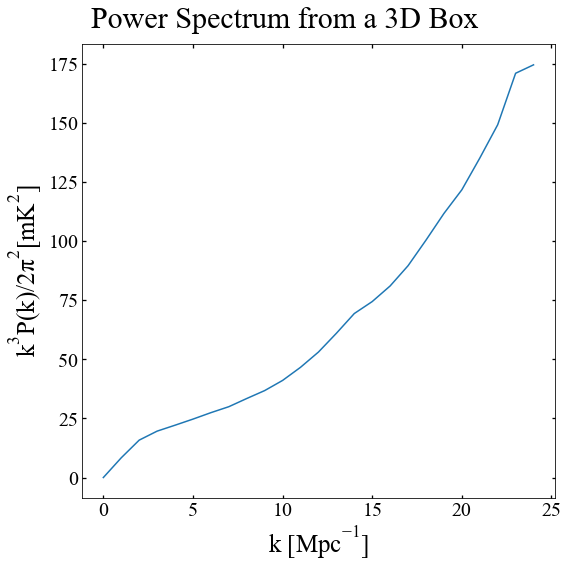

<function __main__.power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma)>

In [23]:
generate_pk_3D(box_4, 128, 25, 0.03)

In [24]:
box_5 = btemp_boxes[4]
print(box_5.shape)
print(redshifts[4])

(128, 128, 128)
9.5


[0.0, 0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547]
[0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547, 5.441398092702653]
[2714862.4039937463, 9328.6778

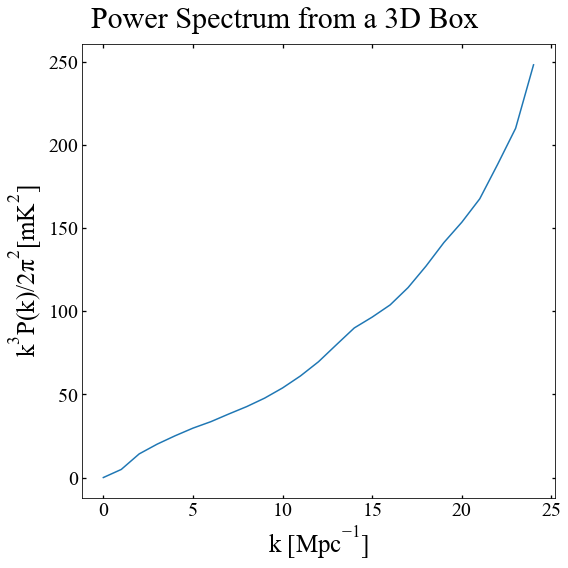

<function __main__.power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma)>

In [25]:
generate_pk_3D(box_5, 128, 25, 0.03)

In [26]:
box_6 = btemp_boxes2[0]
print(box_6.shape)
print(redshifts2[0])

(128, 128, 128)
10.5


[0.0, 0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547]
[0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547, 5.441398092702653]
[3777456.1940287333, 4992.7186

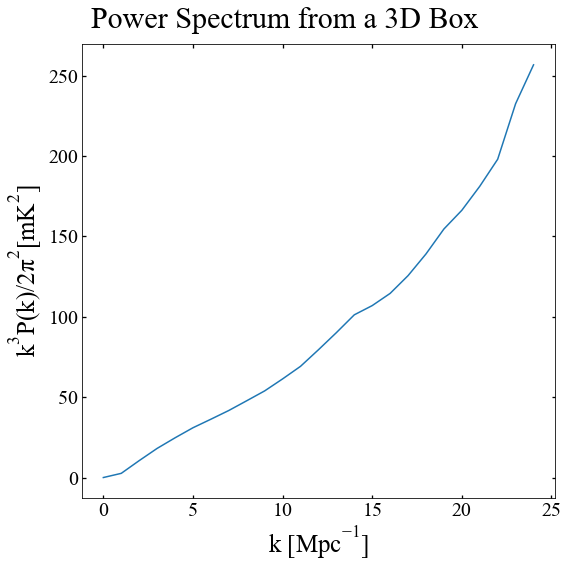

<function __main__.power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma)>

In [27]:
generate_pk_3D(box_6, 128, 25, 0.03)

In [28]:
box_7 = btemp_boxes2[1]
print(box_7.shape)
print(redshifts2[1])

(128, 128, 128)
11.5


[0.0, 0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547]
[0.21765592370810613, 0.43531184741621226, 0.6529677711243184, 0.8706236948324245, 1.0882796185405306, 1.3059355422486367, 1.5235914659567429, 1.741247389664849, 1.9589033133729552, 2.176559237081061, 2.3942151607891673, 2.6118710844972735, 2.8295270082053796, 3.0471829319134858, 3.264838855621592, 3.482494779329698, 3.7001507030378042, 3.9178066267459104, 4.135462550454016, 4.353118474162122, 4.570774397870228, 4.788430321578335, 5.006086245286441, 5.223742168994547, 5.441398092702653]
[4711686.70143504, 4160.955299

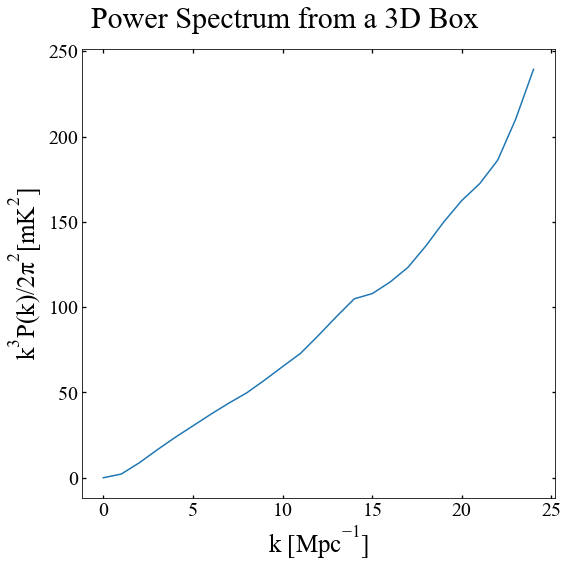

<function __main__.power_spectra_plot_rescaled(input_k, fourier_array, start, end, sigma)>

In [29]:
generate_pk_3D(box_7, 128, 25, 0.03)

In [30]:
#Creating the power spectra arrays
#Does NOT return a plot
def power_spectra_array_rescaled(input_k, fourier_array, start, end, sigma):
    
    #Getting the average fourier value for the chosen k range
    avg_values = avg_corresponding_values(input_k, fourier_array, start, end)
    print(avg_values)
    
    #Rescaling the y-axis
    rescaled_values  = (np.power(start,3) * avg_values)/(2*np.pi**2)
    
    #List of integers from our chosen range value will be the labels for the x-axis
    range_values = list(range(len(start)))
    
    return range_values, rescaled_values



#Changing a Few things for inputting real data
def generate_pk_3D (toy_box, npix, num_bins, sigma):
    
    #Fourier transforming box (shifts included)
    k_box = cosmo_transform(toy_box)
    
    #Squaring values to find amplitude array
    amplitude = np.abs(k_box)**2
    
    #Dividing by original volume of box
    Volume = (npix)**3
    
    #Getting the power spectra
    P_k = (amplitude/Volume)
    
    #Creating frequency arrays
    #THIS IS THE K_X ARRAY
    k_x = kx_frequency_array(npix)
    #THIS IS THE K_Y ARRAY
    k_y = ky_frequency_array(npix)
    #THIS IS THE K_Z ARRAY
    k_z = kz_frequency_array(npix)
    #Creating an array matching our toy box array
    kfreq3D = np.meshgrid(k_x, k_y, k_z, indexing="ij")
    
    #Normalisation factor
    #Finding distance between pixels
    k_values = np.sqrt(kfreq3D[0]**2 + kfreq3D[1]**2 + kfreq3D[2]**2)

    #Finding the maximum value of the k array
    max_k = np.max(k_values)
    
    #Defining the starting and ending arrays
    start, end = create_bins(max_k, num_bins)
    
    #Finding the element positions of the k-array using our given k value ranges
    rings = find_element_positions(k_values, start, end)
    
    #Getting the corresponding fourier array values given positions
    co_values = get_corresponding_values(k_values, P_k, start, end)
    
    #Finding the average of all of these values at each index of 2D array
    averages = avg_corresponding_values(k_values, P_k, start, end)
   
    #Creating the power_spectra ARRAYS
    range_values, rescaled_values = power_spectra_array_rescaled(k_values, P_k, start, end, sigma)
    
    return range_values, rescaled_values

In [31]:
#Defining the Power Spectra array values

range1, rescale1 = generate_pk_3D(box_1, 128, 25, 0.03)
range2, rescale2 = generate_pk_3D(box_2, 128, 25, 0.03)
range3, rescale3 = generate_pk_3D(box_3, 128, 25, 0.03)
range4, rescale4 = generate_pk_3D(box_4, 128, 25, 0.03)
range5, rescale5 = generate_pk_3D(box_5, 128, 25, 0.03)
range6, rescale6 = generate_pk_3D(box_6, 128, 25, 0.03)
range7, rescale7 = generate_pk_3D(box_7, 128, 25, 0.03)

[9722.376707716425, 1324.018315555455, 184.1065441669031, 55.730546605747406, 23.95827904672135, 12.133668904526038, 7.30891759558374, 4.696896943811553, 3.284688197544265, 2.4660676192983555, 1.99914543463902, 1.6562267278636364, 1.4490615177115171, 1.3054300362684232, 1.196285892760513, 1.0387313059963967, 0.93740449286024, 0.8885923238790754, 0.8379689123661901, 0.797801719731915, 0.7667767848004928, 0.7280531648907879, 0.6953058512730885, 0.7204087635138594, 0.7351509848636009]
[100915.82231520822, 6337.931297583276, 917.3389711516504, 285.9903566890832, 123.45769791504094, 65.46448422747105, 39.354612366552765, 26.081587139466418, 18.700839223277708, 14.195916477580752, 11.375146575747099, 9.613454346996921, 8.467773408732137, 7.640806183448269, 6.98023389191811, 6.129942905375659, 5.610483312894271, 5.186191960507914, 5.006394824335883, 4.739798572287418, 4.432043802435049, 4.243586568874513, 4.037099152325792, 4.153912363089845, 4.258204148400526]
[610171.9624606611, 15530.35113

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

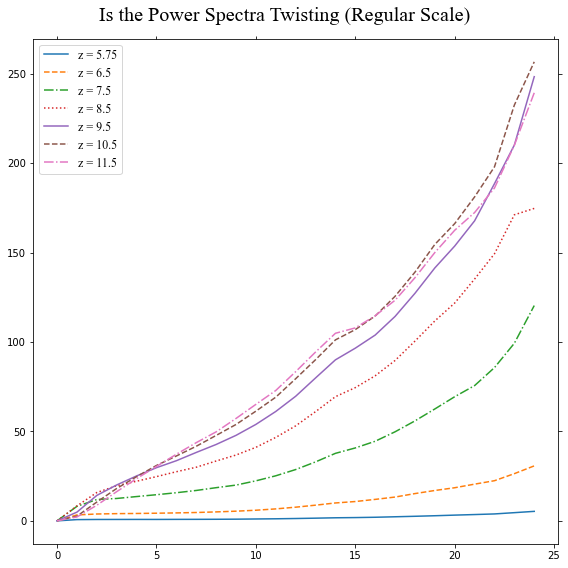

In [33]:
#Creating Plot Comparing Power Spectra
plt.figure(figsize = (8,8))
plt.style.use("fast")
hfont = {'fontname':'Times New Roman'}

#Plotting all the Power Spectra
plt.plot(range1, rescale1, linestyle = "solid", label = "z = 5.75")
plt.plot(range2, rescale2, linestyle = "dashed", label = "z = 6.5")
plt.plot(range3, rescale3, linestyle = "dashdot", label = "z = 7.5")
plt.plot(range4, rescale4, linestyle = "dotted", label = "z = 8.5")
plt.plot(range5, rescale5, linestyle = "solid", label = "z = 9.5")
plt.plot(range6, rescale6, linestyle = "dashed", label = "z = 10.5")
plt.plot(range7, rescale7, linestyle = "dashdot", label = "z = 11.5")

#Plot Specifications
plt.suptitle("Is the Power Spectra Twisting (Regular Scale)", size = 20, **hfont)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.legend(loc="best", prop={'family': 'Times New Roman', 'size': 12})
plt.tight_layout()
plt.show()

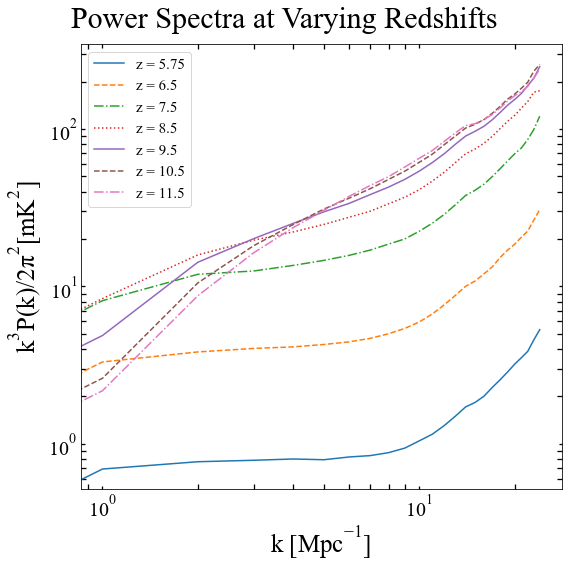

In [34]:
#Creating Plot Comparing Power Spectra
F1 = plt.figure(figsize = (8,8))
plt.style.use("fast")
hfont = {'fontname':'Times New Roman'}

#Plotting all the Power Spectra
plt.plot(range1, rescale1, linestyle = "solid", label = "z = 5.75")
plt.plot(range2, rescale2, linestyle = "dashed", label = "z = 6.5")
plt.plot(range3, rescale3, linestyle = "dashdot", label = "z = 7.5")
plt.plot(range4, rescale4, linestyle = "dotted", label = "z = 8.5")
plt.plot(range5, rescale5, linestyle = "solid", label = "z = 9.5")
plt.plot(range6, rescale6, linestyle = "dashed", label = "z = 10.5")
plt.plot(range7, rescale7, linestyle = "dashdot", label = "z = 11.5")

#Axes are Log Scale
#But we still have linear binning
plt.yscale("log")
plt.xscale("log")

#Labels
plt.xlabel(r"k [$\mathregular{Mpc^{-1}}$]", size=25, **hfont) 
plt.ylabel(r"$\mathregular{k^3 P(k)/2\pi^{2} [mK^2]}$", size = 25, **hfont) 
plt.suptitle("Power Spectra at Varying Redshifts", size = 30, **hfont)

#Tick Parameters
plt.tick_params(bottom=True, top=True, left=True, right=True, which='major', 
                direction = "in", labelsize=20, width=1.3, color='black')
plt.tick_params(top= True, right = True, axis='both', which='minor', direction='in', 
                labelsize = 20, length=5, width=1.3)
plt.yticks(fontname = "Times New Roman") 
plt.xticks(fontname = "Times New Roman") 

#Remaining Plot Specifications
plt.legend(loc="best", prop={'family': 'Times New Roman', 'size': 15})
plt.tight_layout()
plt.show()

#F1.savefig("Comparing Power Spectra", format="png", dpi=1200)

/var/folders/lv/gfzpkwvx05n74hs4k8j4r9t00000gn/T/ipykernel_19643/282615161.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


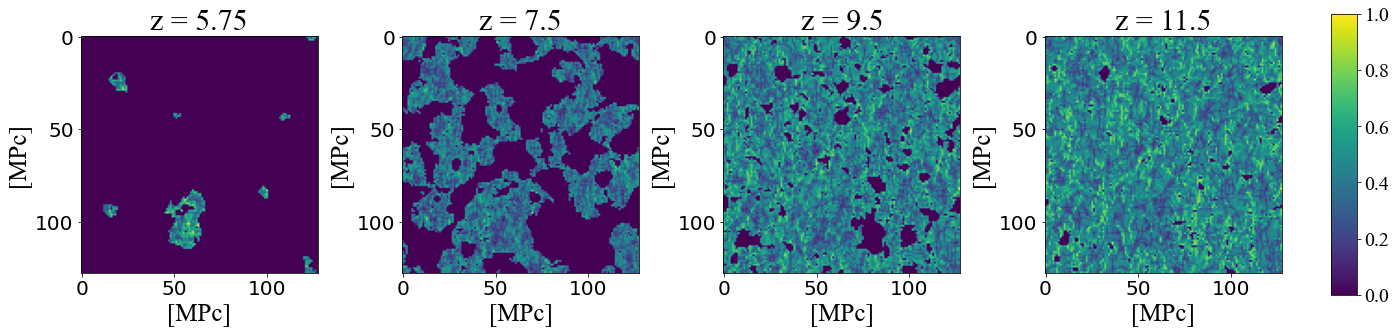

<Figure size 432x288 with 0 Axes>

In [35]:
#Displaying Multiple Figures at Once for Comparison
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (18, 15))
hfont = {'fontname':'Times New Roman'}
plt.rcParams['font.family'] = 'Times New Roman'

#Figure 1
ax1.imshow(btemp_boxes[0][0])
ax1.set_title("z = 5.75", size = 30, **hfont)
ax1.set_xlabel('[MPc]', fontsize=25, **hfont)
ax1.set_ylabel('[MPc]', fontsize=25, **hfont)
ax1.tick_params(axis='both', which='major', labelsize = 20)

#Figure 2
ax2.imshow(btemp_boxes[2][0])
ax2.set_title("z = 7.5", size = 30, **hfont)
ax2.set_xlabel('[MPc]', fontsize=25, **hfont)
ax2.set_ylabel('[MPc]', fontsize=25, **hfont)
ax2.tick_params(axis='both', which='major', labelsize = 20)

#Figure 3
ax3.imshow(btemp_boxes[4][0])
ax3.set_title("z = 9.5", size = 30,  **hfont)
ax3.set_xlabel('[MPc]', fontsize=25, **hfont)
ax3.set_ylabel('[MPc]', fontsize=25, **hfont)
ax3.tick_params(axis='both', which='major', labelsize = 20)

#Figure 4
ax4.imshow(btemp_boxes2[1][0])
ax4.set_title("z = 11.5", size = 30, **hfont)
ax4.set_xlabel('[MPc]', fontsize=25, **hfont)
ax4.set_ylabel('[MPc]', fontsize=25, **hfont)
ax4.tick_params(axis='both', which='major', labelsize = 20)

#Add a colorbar axis
cax = fig.add_axes([1.03, 0.37, 0.02, 0.26])

#Create a ScalarMappable object for mapping scalar data to colors
sm = plt.cm.ScalarMappable()
sm.set_array([])

#Add the colorbar to the colorbar axis
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=20)

#Remaining Plot Specifications
plt.tight_layout()
plt.show()
plt.subplots_adjust(right=0.85)

#fig.savefig("Comparing btemp redshifts", format="png", dpi=1200)

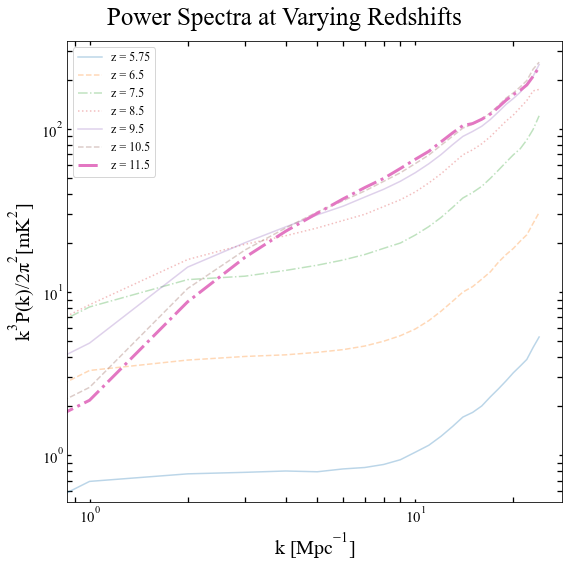

In [36]:
#Creating Plot Comparing Power Spectra
F2 = plt.figure(figsize = (8,8))
plt.style.use("fast")
hfont = {'fontname':'Times New Roman'}

#Plotting all the Power Spectra
plt.plot(range1, rescale1, linestyle = "solid", label = "z = 5.75", alpha = 0.3)
plt.plot(range2, rescale2, linestyle = "dashed", label = "z = 6.5", alpha = 0.3)
plt.plot(range3, rescale3, linestyle = "dashdot", label = "z = 7.5", alpha = 0.3)
plt.plot(range4, rescale4, linestyle = "dotted", label = "z = 8.5", alpha = 0.3)
plt.plot(range5, rescale5, linestyle = "solid", label = "z = 9.5",alpha = 0.3)
plt.plot(range6, rescale6, linestyle = "dashed", label = "z = 10.5", alpha = 0.3)
plt.plot(range7, rescale7, linestyle = "dashdot", label = "z = 11.5", linewidth = 3)

#Axes are Log Scale
#But we still have linear binning
plt.yscale("log")
plt.xscale("log")

#Labels
plt.xlabel(r"k [$\mathregular{Mpc^{-1}}$]", size=20, **hfont) 
plt.ylabel(r"$\mathregular{k^3 P(k)/2\pi^{2} [mK^2]}$", size = 20, **hfont) 
plt.suptitle("Power Spectra at Varying Redshifts", size = 25, **hfont)

#Tick Parameters
plt.tick_params(bottom=True, top=True, left=True, right=True, which='major', 
                direction = "in", labelsize=15, width=1.3, color='black')
plt.tick_params(top= True, right = True, axis='both', which='minor', direction='in', 
                labelsize = 12, length=5, width=1.3)
plt.yticks(fontname = "Times New Roman") 
plt.xticks(fontname = "Times New Roman") 

#Remaining Plot Specifications
plt.legend(loc="best", prop={'family': 'Times New Roman', 'size': 12})
plt.tight_layout()
plt.show()

#F2.savefig("Comparing Power Spectra Redshift 11.5", format="png", dpi=1200)

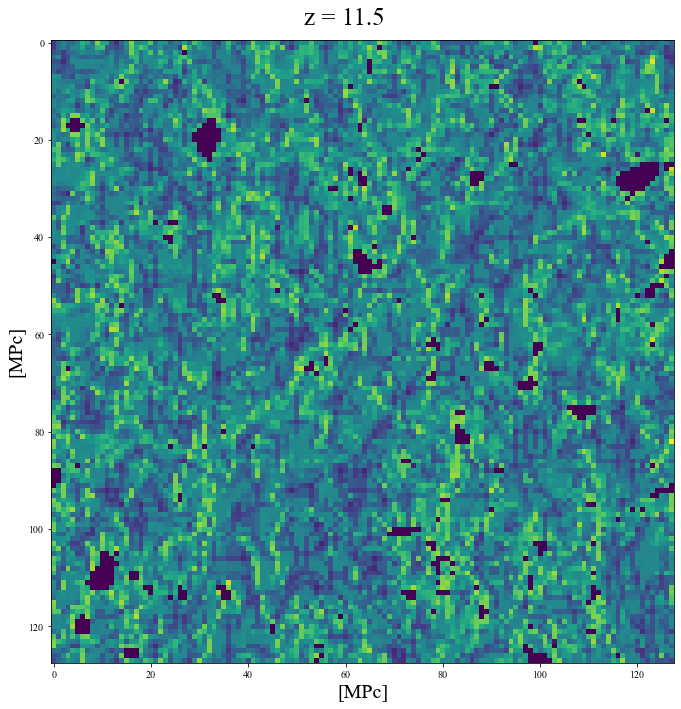

In [37]:
#Displaying Single Brightness Temperature Box
F3 = plt.figure(figsize = (10, 10))
hfont = {'fontname':'Times New Roman'}
plt.rcParams['font.family'] = 'Times New Roman'

#z = 11.5
plt.imshow(btemp_boxes2[1][0])
plt.suptitle("z = 11.5", size = 25, **hfont)
plt.xlabel('[MPc]', fontsize=20, **hfont)
plt.ylabel('[MPc]', fontsize=20, **hfont)
plt.tick_params(axis='both', which='major')

#Remaining Plot Specifications
plt.tight_layout()
plt.show()

#F3.savefig("Comparing btemp redshifts z = 11.5", format="png", dpi=1200)

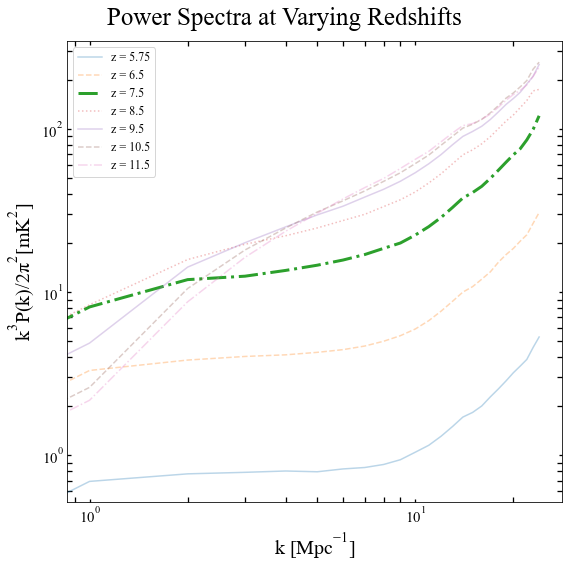

In [38]:
#Creating Plot Comparing Power Spectra
F2 = plt.figure(figsize = (8,8))
plt.style.use("fast")
hfont = {'fontname':'Times New Roman'}

#Plotting all the Power Spectra
plt.plot(range1, rescale1, linestyle = "solid", label = "z = 5.75", alpha = 0.3)
plt.plot(range2, rescale2, linestyle = "dashed", label = "z = 6.5", alpha = 0.3)
plt.plot(range3, rescale3, linestyle = "dashdot", label = "z = 7.5", linewidth = 3)
plt.plot(range4, rescale4, linestyle = "dotted", label = "z = 8.5", alpha = 0.3)
plt.plot(range5, rescale5, linestyle = "solid", label = "z = 9.5",alpha = 0.3)
plt.plot(range6, rescale6, linestyle = "dashed", label = "z = 10.5", alpha = 0.3)
plt.plot(range7, rescale7, linestyle = "dashdot", label = "z = 11.5", alpha = 0.3)

#Axes are Log Scale
#But we still have linear binning
plt.yscale("log")
plt.xscale("log")

#Labels
plt.xlabel(r"k [$\mathregular{Mpc^{-1}}$]", size=20, **hfont) 
plt.ylabel(r"$\mathregular{k^3 P(k)/2\pi^{2} [mK^2]}$", size = 20, **hfont) 
plt.suptitle("Power Spectra at Varying Redshifts", size = 25, **hfont)

#Tick Parameters
plt.tick_params(bottom=True, top=True, left=True, right=True, which='major', 
                direction = "in", labelsize=15, width=1.3, color='black')
plt.tick_params(top= True, right = True, axis='both', which='minor', direction='in', 
                labelsize = 12, length=5, width=1.3)
plt.yticks(fontname = "Times New Roman") 
plt.xticks(fontname = "Times New Roman") 

#Remaining Plot Specifications
plt.legend(loc="best", prop={'family': 'Times New Roman', 'size': 12})
plt.tight_layout()
plt.show()

#F2.savefig("Comparing Power Spectra Redshift 7.5", format="png", dpi=1200)

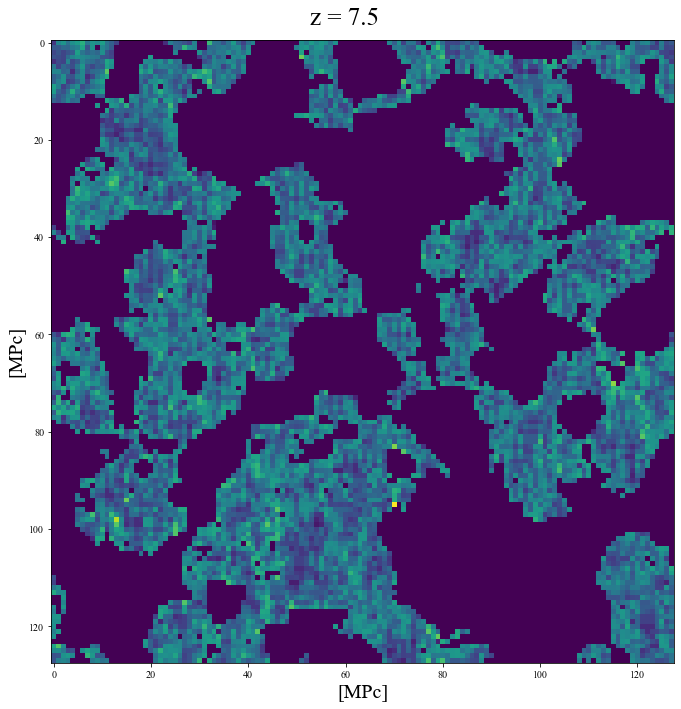

In [39]:
#Displaying Single Brightness Temperature Box
F3 = plt.figure(figsize = (10, 10))
hfont = {'fontname':'Times New Roman'}
plt.rcParams['font.family'] = 'Times New Roman'

#z = 7.5
plt.imshow(btemp_boxes[2][0])
plt.suptitle("z = 7.5", size = 25, **hfont)
plt.xlabel('[MPc]', fontsize=20, **hfont)
plt.ylabel('[MPc]', fontsize=20, **hfont)
plt.tick_params(axis='both', which='major')

#Remaining Plot Specifications
plt.tight_layout()
plt.show()

#F3.savefig("Comparing btemp redshifts z = 7.5", format="png", dpi=1200)

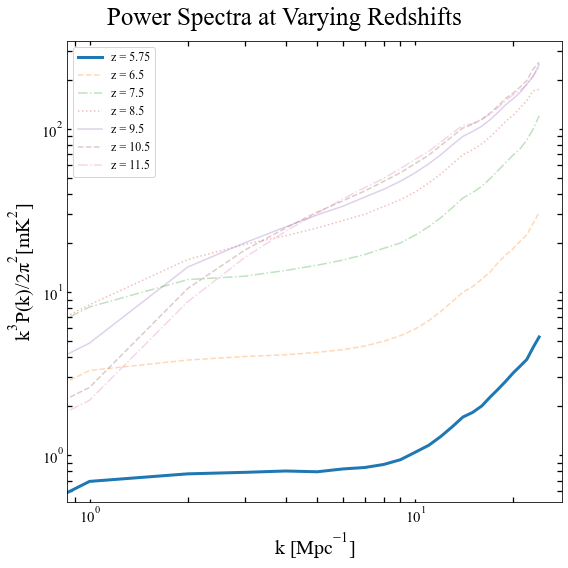

In [40]:
#Creating Plot Comparing Power Spectra
F3 = plt.figure(figsize = (8,8))
plt.style.use("fast")
hfont = {'fontname':'Times New Roman'}

#Plotting all the Power Spectra
plt.plot(range1, rescale1, linestyle = "solid", label = "z = 5.75", linewidth = 3)
plt.plot(range2, rescale2, linestyle = "dashed", label = "z = 6.5", alpha = 0.3)
plt.plot(range3, rescale3, linestyle = "dashdot", label = "z = 7.5", alpha = 0.3)
plt.plot(range4, rescale4, linestyle = "dotted", label = "z = 8.5", alpha = 0.3)
plt.plot(range5, rescale5, linestyle = "solid", label = "z = 9.5",alpha = 0.3)
plt.plot(range6, rescale6, linestyle = "dashed", label = "z = 10.5", alpha = 0.3)
plt.plot(range7, rescale7, linestyle = "dashdot", label = "z = 11.5", alpha = 0.3)

#Axes are Log Scale
#But we still have linear binning
plt.yscale("log")
plt.xscale("log")

#Labels
plt.xlabel(r"k [$\mathregular{Mpc^{-1}}$]", size=20, **hfont) 
plt.ylabel(r"$\mathregular{k^3 P(k)/2\pi^{2} [mK^2]}$", size = 20, **hfont) 
plt.suptitle("Power Spectra at Varying Redshifts", size = 25, **hfont)

#Tick Parameters
plt.tick_params(bottom=True, top=True, left=True, right=True, which='major', 
                direction = "in", labelsize=15, width=1.3, color='black')
plt.tick_params(top= True, right = True, axis='both', which='minor', direction='in', 
                labelsize = 12, length=5, width=1.3)
plt.yticks(fontname = "Times New Roman") 
plt.xticks(fontname = "Times New Roman") 

#Remaining Plot Specifications
plt.legend(loc="best", prop={'family': 'Times New Roman', 'size': 12})
plt.tight_layout()
plt.show()

#F3.savefig("Comparing Power Spectra Redshift 5.75", format="png", dpi=1200)

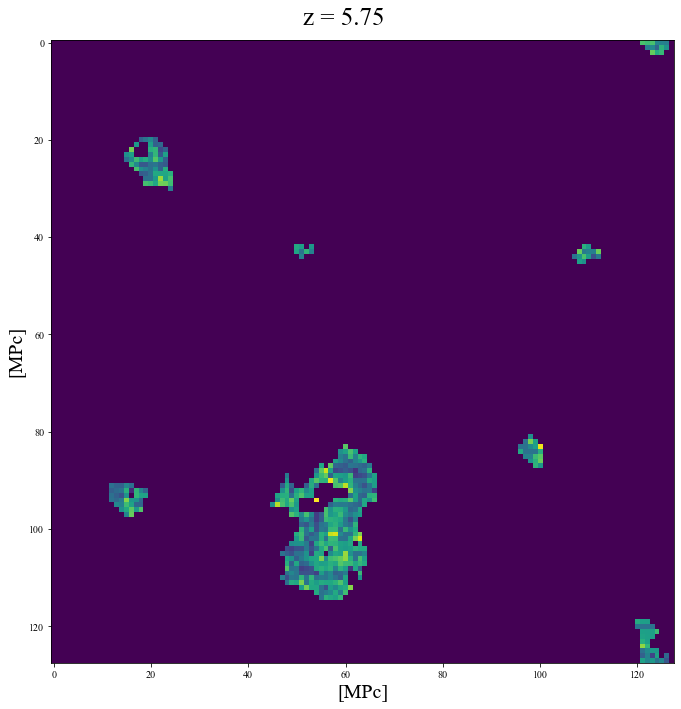

In [41]:
#Displaying Single Brightness Temperature Box
F3 = plt.figure(figsize = (10, 10))
hfont = {'fontname':'Times New Roman'}
plt.rcParams['font.family'] = 'Times New Roman'

#z = 5.75
plt.imshow(btemp_boxes[0][0])
plt.suptitle("z = 5.75", size = 25, **hfont)
plt.xlabel('[MPc]', fontsize=20, **hfont)
plt.ylabel('[MPc]', fontsize=20, **hfont)
plt.tick_params(axis='both', which='major')

#Remaining Plot Specifications
plt.tight_layout()
plt.show()

#F3.savefig("Comparing btemp redshifts z = 5.75", format="png", dpi=1200)